# Chopping Up Corporate Churn

#### Note: code is hidden on some cells for readability, but it can be toggled back on using the carat in the toolbar.

## The data
The finance department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "bonus" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

## The challenge
Create a report that covers the following:

1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?

## Import Packages

In [1]:
# Import Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## Exploring the Data (EDA)

In [2]:
# Snapshot of Data
df = pd.read_csv('employee_churn_data.csv')
index = df.index
index.name = "Snapshot of Corporate Churn Data"
display(df.head())
df.info()
isna = df.isna().any()
isna.name = "Any Missing Values?"
display(isna)
df.describe()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
Snapshot of Corporate Churn Data,,,,,,,,,,
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


department       False
promoted         False
review           False
projects         False
salary           False
tenure           False
satisfaction     False
bonus            False
avg_hrs_month    False
left             False
Name: Any Missing Values?, dtype: bool

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


The data is tidy, with each employee occupying a single row. There are 9540 employees recorded, and 10 variables per employee. There is no missing data. In the statistical summary table, we can see that at least 75% of employees have not received a promotion or a bonus in the previous 24 months. This is our first clue as to why employees have been fleeing the company. We also note that the average employee receives a review score of 0.65/1, the average employee has around 3 projects, they have been working at the company for 6 and a half years, they have a satisfaction score of 0.5/1, and they work on average 185 hours per month, which is longer than the normal 40 hr work week.

,department,employees,left_yes,left_per_100
3,finance,402,108,26.865672
1,admin,423,119,28.132388
8,sales,1883,537,28.518322
6,operations,1522,436,28.646518
2,engineering,1516,437,28.825858
9,support,735,212,28.843537
5,marketing,802,243,30.299252
7,retail,1541,471,30.564568
4,logistics,360,111,30.833333
0,IT,356,110,30.898876


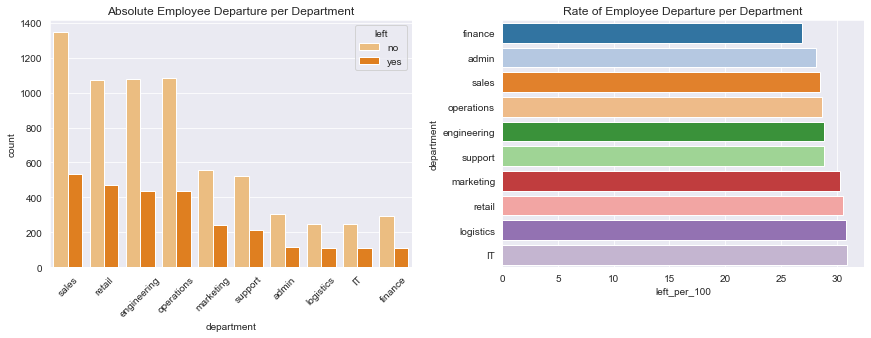

In [3]:
# Count the number of employees in each department
dpmt = df.groupby('department', as_index=False)['left'].count()

# Count the number of employees that have left in each department
left_yes = df[df['left'] == 'yes']
dpmt_left = left_yes.groupby('department', as_index=False)['left'].count()

# Combine DataFrames
dpmt['left_yes'] = dpmt_left['left']
dpmt.columns = ['department', 'employees', 'left_yes']

# Add 'left_per_100' column
dpmt['left_per_100'] = dpmt['left_yes']/dpmt['employees'] * 100
display(dpmt.sort_values('left_per_100'))

# Set Seaborn graph styling
sns.set_style('darkgrid')
p = sns.color_palette('Paired')

# Graph employee departure per department in absolute terms
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.tight_layout()
plt.subplots_adjust(wspace=.25)
sns.countplot(x='department', hue='left', data=df, palette=p[6:8], ax=ax1, order=dpmt.sort_values(
    'left_yes', ascending=False).department.values)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Absolute Employee Departure per Department')

# Graph employee departure per department in relative terms
sns.barplot(y='department', x='left_per_100', data=dpmt, orient='h', ax=ax2,
            palette='tab20', order=dpmt.sort_values('left_per_100').department.values)
ax2.set_title('Rate of Employee Departure per Department')
plt.show()

One of our first goals is to determine which departments have the lowest and highest employee turnover. In absolute terms, we can see that sales is the largest department, and it has lost the greatest number of employees (537); meanwhile finance is one of the smallest departments, and it has lost the least employees (108). However, when you normalize the departments based on their overall size, you see that there is not much difference between them. IT has the highest rate of churn (31%), and finance has the lowest rate (27%). A difference of four percent indicates that this is more of a company wide problem rather than something relegated to a few departments. According to this article: https://www.dailypay.com/resource-center/blog/employee-retention-rate/#:~:text=A%20s%20mentioned%20earlier%2C%2010%25%20is%20a%20good,to%20be%20replaced%20with%20engaged%2C%20high-performing%20team%20members, 10% is a good figure to aim for as an average employee churn rate. Let's dive deeper to determine what systematic flaws are contributing to the high churn at the company.

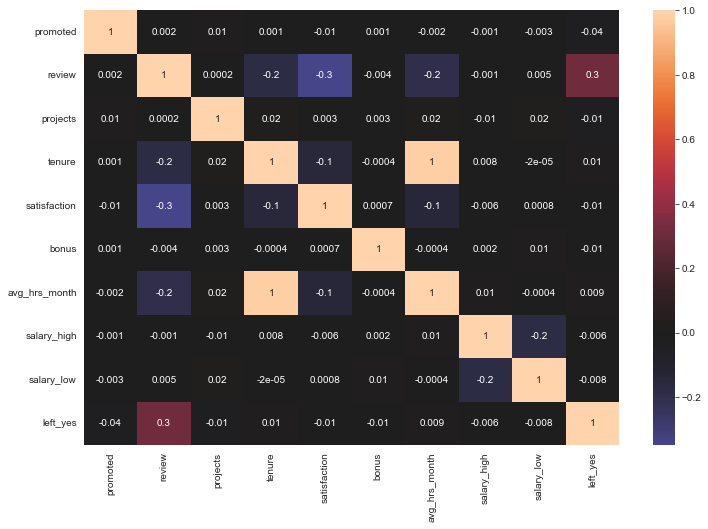

In [4]:
# Explore trends within the data using a correlation heatmap
fig = plt.gcf()
fig.set_size_inches(12, 8)
df_pp = pd.get_dummies(df.drop('department', axis='columns'))
df_pp = df_pp.drop(['salary_medium', 'left_no'], axis='columns')
sns.heatmap(df_pp.corr(), annot=True, fmt='.1g', vmax=1, center=0)

Using a correlation heatmap, we can quickly tell that the average hours an employee works increases the longer they stay with the company. If we reference the earlier statistical summary table, it says that at least 75% of employees work more than 40 hours a week. This is not ideal for anybody who values a healthy work-life-balance. There is a slight positive correlation between churn and review score, and a negative correlation between satisfaction and review score that requires further investigation.

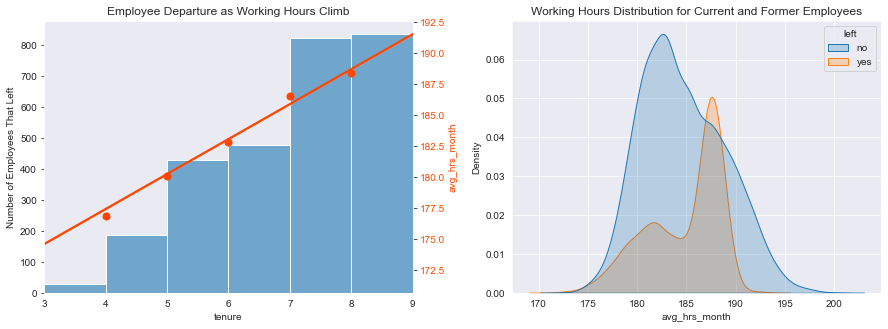

In [5]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.27)

# Graph employee departure distribution against tenure
sns.histplot(x='tenure', data=left_yes, bins=7,
             ax=ax1, alpha=0.6).set(xlim=(3, 9))
ax1.set_title('Employee Departure as Working Hours Climb')
ax1.set_ylabel('Number of Employees That Left')
ax1.grid(False)

# Graph working hours against tenure along the same x-axis
twin1 = ax1.twinx()
sns.regplot(y='avg_hrs_month', x='tenure', data=left_yes,
            x_bins=20, ax=twin1, color='orangered')
twin1.set_ylabel(ylabel='avg_hrs_month', c='orangered')
twin1.tick_params(axis='y', labelcolor='orangered')
twin1.grid(False)

# Graph the distribution of work hours for current and former employees
sns.kdeplot(x='avg_hrs_month', data=df, hue='left', fill=True, ax=ax2).set(
    title='Working Hours Distribution for Current and Former Employees')

The first graph clearly displays the correlation between average monthly working hours and employee departure. It is undeniable that overworking employees can cause burnout, which then leads to resignations. The biggest jumps in churn occur when employees cross 180 and 185 working hours per month after their fifth and seventh years respectively.

The second plot distinguishes how these long working hours affect groups of employees differently. A majority of employee work about 183 hours a month. However, a smaller but sizable group is working about 187 hours per month. This second group is made up of employees that eventually leave the company. In fact, the second graph shows a bimodal distribution for former employees, and the peaks coincide with the jumps in churn. This analysis says that employees have their limits, and increasing working hours causes churn. 

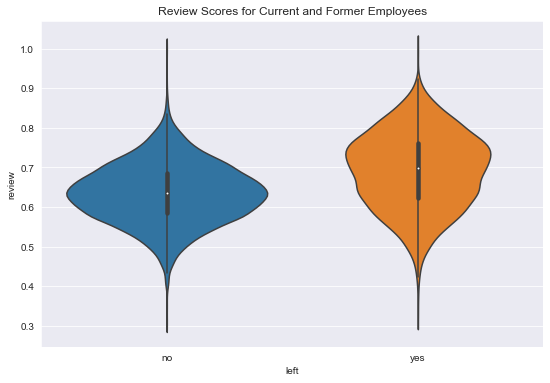

In [6]:
# Graph the distribution and median review scores for employees that stayed and those who left
sns.violinplot(x='left', y='review', data=df).set(
    title="Review Scores for Current and Former Employees")
fig = plt.gcf()
fig.set_size_inches(9, 6)

This graphs help us visualize the correlations between review scores for current and former employees. The employees that stay with the company have a concentrated review score that is usually about a point lower than those who leave. This means that highly valued employees are more likely to leave, an extremely troubling and puzzling discovery. We must determine the reason for this disparity.

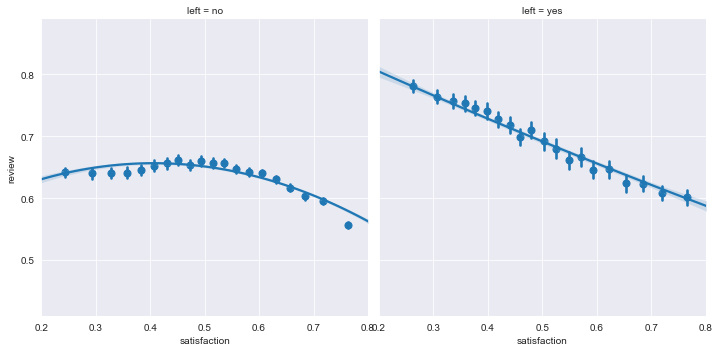

In [7]:
# Graph the review vs satisfaction scores of current and former employees
g = sns.lmplot(y='review', x='satisfaction', data=df,
               x_bins=20, order=2, col='left')
g.set(xlim=(0.2, 0.8))

These graphs highlight a clear difference between current and former employees; current employee satisfaction at work is mostly unaffected by how the company reviews them, although there is a slight negative correlation for the most satisfied employees. On the other hand, former employees have a strong negative correlation between their satisfaction and review scores. It seems that the happier these employees feel, the worse their performance is in the eyes of the company. This negative correlation is another variable that we can use to predict churn.

Current Employees Avg Review Score: 0.635163672768492
Resigned Employees Avg Review Score: 0.6922619851915817


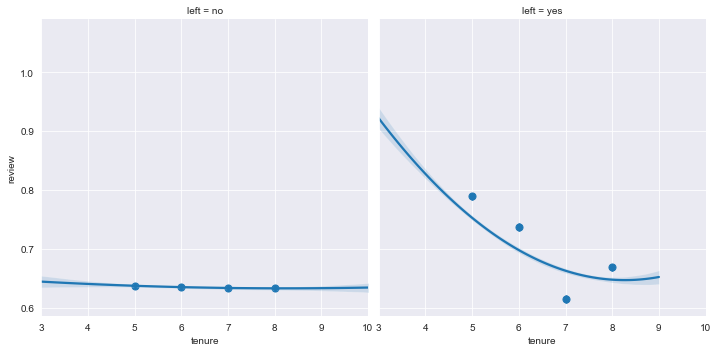

In [8]:
# Graph the review scores vs tenure of current and former employees
h = sns.lmplot(y='review', x='tenure', data=df, x_bins=4, order=2, col='left')
h.set(xlim=(3, 10))

left_no = df[df['left'] == 'no']
print(f'Current Employees Avg Review Score: {left_no.review.mean()}')
print(f'Resigned Employees Avg Review Score: {left_yes.review.mean()}')

One of the key differences between employees who stay and those who resign is their review score over time. Current employees are reviewed, on average, .6 points less than past employees. Furthermore, current employees have consistent review scores throughout their tenure (~0.64), while past employees usually start out with much higher review scores (>0.8) that decline over time. If an employee's review never changes, then they feel consistent and are less likely to leave; however, if their review declines over time, despite feeling more satisfaction, they would feel like they are regressing and would wish to make a career change.

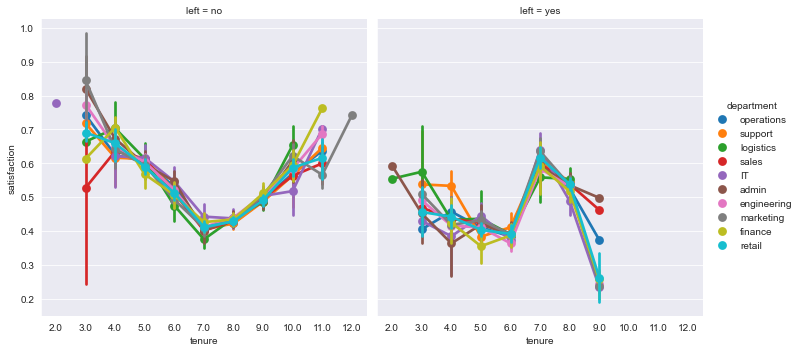

In [9]:
# Graph the satisfaction of employees across different departments
sns.catplot(x='tenure', y='satisfaction', data=df,
            col='left', hue='department', kind='point')

These graphs show how the derivative of satisfaction over tenure is a sign that an employee might leave. In other words, an employee is more likely to leave if their satisfaction score increases between years 6 and 7, whereas a current employee is likely to see their satisfaction score decrease in that same time-frame. These rates of change are similar across all departments. 

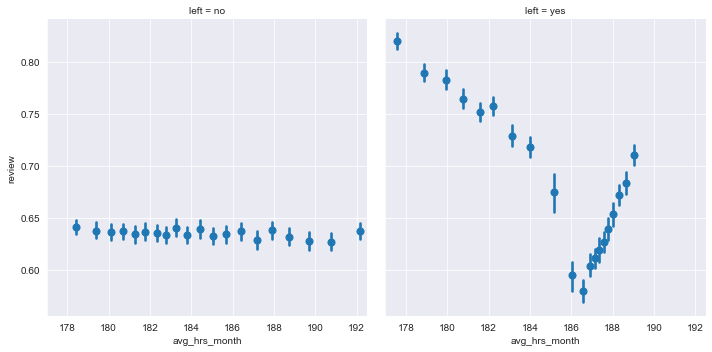

In [10]:
# Graph the review vs avg hours worked scores of current and former employees
g = sns.lmplot(y='review', x='avg_hrs_month', data=df,
               x_bins=20, fit_reg=False, col='left')
g.set(xlim=(177, 192.5))

A large jump in employee departure happens after year 7, which coincides with longer working hours. This time is probably a breaking point for many employees because their satisfaction scores start to plummet even though their review score is increasing. This tension might even create negative feelings toward the company because they feel like the company is relishing the fact that they are working longer despite the employee's happiness. Meanwhile, employees who stay review the same regardless of how many hours they worked.

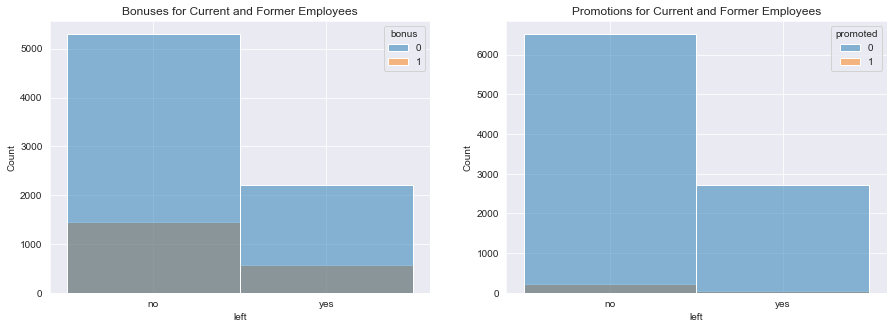

In [11]:
# Graph the differences in bonuses and promotions for current and former employees
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x='left', hue='bonus', data=df, ax=ax1).set(
    title='Bonuses for Current and Former Employees')
sns.histplot(x='left', hue='promoted', data=df, ax=ax2).set(
    title='Promotions for Current and Former Employees')

Lastly, it seems like instead of giving out promotions or bonuses, the company is trying to use the review scores to keep employees, but that is not working. These figures show that current employees have had a higher number of bonuses and promotions, which is likely what keeps them from leaving despite increasing working hours.

## EDA Summary

In summary, the most important variables that indicate an employee is likely to leave are:
1. High working hours.
2. A negative correlation between review score and satisfaction score.
3. Declining review scores.
4. A satisfaction score/tenure differential that matches those of other employees ready to leave.
5. A lack of bonuses or promotions in the past 24 months.

Next, we use supervised machine learning to determine whether we can reliably predict whether an employee has left based on their data, thereby confirming these conclusions.

## Supervised Machine Learning

This problem is a classification problem. Our target variables fall into two categories: stayed or left. 

In [30]:
# Import necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [22]:
# Preprocess all categorical data
df_og = pd.get_dummies(df)
df_og = df_og.drop(['left_no', 'salary_medium'], axis=1)
df_og.head()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month,department_IT,department_admin,department_engineering,department_finance,department_logistics,department_marketing,department_operations,department_retail,department_sales,department_support,salary_high,salary_low,left_yes
Snapshot of Corporate Churn Data,,,,,,,,,,,,,,,,,,,,
0,0,0.577569,3,5.0,0.626759,0,180.866070,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0.751900,3,6.0,0.443679,0,182.708149,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0.722548,3,6.0,0.446823,0,184.416084,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0.675158,4,8.0,0.440139,0,188.707545,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0.676203,3,5.0,0.577607,1,179.821083,0,0,0,0,0,0,0,0,1,0,1,0,0


In [25]:
# Split all the data into features and target variables
features_og = df_og.iloc[:, 0:19]
target_og = df_og.iloc[:, 19]
feature_names_og = list(features_og.columns)
target_names_og = list(pd.DataFrame(target_og).columns)
df_names_og = list(df_og.columns)
target_names_og

['left_yes']

In [26]:
# Use k-Nearest Neighbors to predict on all the data
X_train, X_test, y_train, y_test = train_test_split(
    features_og, target_og, test_size=0.3, random_state=21, stratify=target_og)

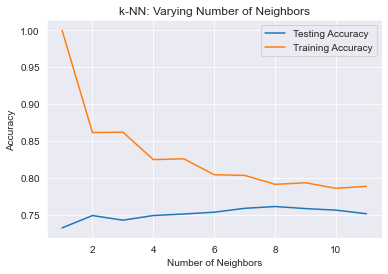

Average cross validation score: 0.7485324947589098


In [27]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 12)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

# Cross validation
cv_results = cross_val_score(knn, features_og, target_og, cv=10)
print(f"Average cross validation score: {np.mean(cv_results)}")

In [28]:
# Determine the accuracy of KNN over all data
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy: {}".format(knn.score(X_test, y_test)))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7610062893081762
[[1907  120]
 [ 564  271]]


The accuracy of KNN over all the data is about 76%, which is close enough to the average cross validation score to be reliable. This accuracy is okay, but it could be better. Now, let's try the same evaluation after removing some of the features that don't affect churn.

In [33]:
# Preprocess select categorical data

# Drop department and salary columns becuase they showed little affect on churn in the data analysis section
df_dum = df.drop(['department', 'salary'], axis=1)
df_dum = pd.get_dummies(df_dum)
df_dum = df_dum.drop(['left_no', 'projects'], axis=1)
df_dum.head()

,promoted,review,tenure,satisfaction,bonus,avg_hrs_month,left_yes
Snapshot of Corporate Churn Data,,,,,,,
0,0,0.577569,5.0,0.626759,0,180.866070,0
1,0,0.751900,6.0,0.443679,0,182.708149,0
2,0,0.722548,6.0,0.446823,0,184.416084,0
3,0,0.675158,8.0,0.440139,0,188.707545,0
4,0,0.676203,5.0,0.577607,1,179.821083,0


In [34]:
# Split the selected data into features and target variables
features = df_dum.iloc[:, 0:6]
target = df_dum.iloc[:, 6]
feature_names = list(features.columns)
target_names = list(pd.DataFrame(target).columns)
df_names = list(df.columns)
feature_names

['promoted', 'review', 'tenure', 'satisfaction', 'bonus', 'avg_hrs_month']

In [35]:
# Use k-Nearest Neighbors to predict on the selected data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=21, stratify=target)

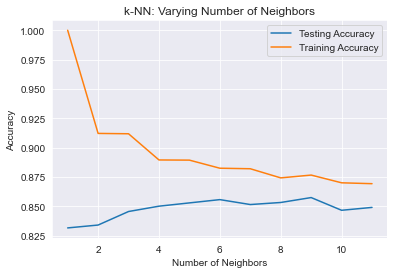

Average cross validation score: 0.8482180293501049


In [36]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 12)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

# Cross validation
cv_results = cross_val_score(knn, features, target, cv=10)
print(f"Average cross validation score: {np.mean(cv_results)}")

By looking at all the columns, the model has an accuracy of 75% But if we look at just the variables 'promoted', 'review', 'tenure', 'satisfaction', 'bonus', and 'avg_hrs_month', the average score is 85%.

In [37]:
# Determine the accuracy of KNN over the selected data
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy: {}".format(knn.score(X_test, y_test)))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8574423480083857
[[1881  146]
 [ 262  573]]


Using 9 nearest neighbors gives us a testing accuracy of 86%! Very close to our average cross validation score and much better than the accuracy we got before eliminating the unnecessary variables.

Next Time: show the accuracy and confusion matrix for all columns, and then try using a random forest and see what kind of accuracy i can get!

## The Challenge Answers

1. IT has the highest turnover when you control for department size. Finance has the lowest.

2. The most important variables that indicate an employee is likely to leave are:

* High working hours.
* A negative correlation between review score and satisfaction score.
* Declining review scores.
* A satisfaction score/tenure differential that matches those of other employees ready to leave.
* A lack of bonuses or promotions in the past 24 months.

3. I would recommend simmering down the growth of working hours for all employees, with the ultimate goal of a 40 hour work week for everone. The long working hours drive churn, so cutting these back will have the most significant effect. I would also create a procedure to reach out to employees with declining review scores in order to understand why they are not performing as well as before. I would also monitor employee satisfaction vs tenure and strategically deploy bonuses and promotions well before employees feel like they must resign.